**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf

from collections import Counter
from nltk.corpus import stopwords
from scipy import stats
from sklearn.feature_extraction import text
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

base_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code'
sys.path.append(base_path)

import util
from text_classification import lr_schedule
from text_classification import plot_distribution, plot_length_distribution, plot_frequency_distribution
from text_classification import Params, TextClassificationHelper
from text_classification import SimpleTextDatasets, SequenceTextDatasets, RawTextDatasets,TransferTextDatasets

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

设置GPU最大内存。

In [3]:
util.set_gpu_memory_growth()
model_results={}

初始化参数。

In [4]:
def lr_schedule(epoch, lr):
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        # ??lr?new_lr???????0.1??new_lr?????lr
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

nltk.download('stopwords')

classes = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']
params = {
    'dataset_name': 'reuters',
    'program_name': util.get_notebook_name(),
    'sample_perecent': 1,    
    'text_column': '',    
    'classes': classes,
    'validation_percent': 0.0,    
    'stop_words':stopwords.words('english'),
    'use_stop_words': True,    
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'dropout':0.1,
    'metrics':['accuracy', metrics.SparseTopKCategoricalAccuracy(k=2)], 
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':120},
        'rnn':{'dropout':0.3, 'embedding_dim':200, 'units':200, 'epochs':20},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':120},
        'sepcnn':{'dropout':0.4, 'epochs': 60, 'batch_size':128},
    }
}

params = Params(params)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 下载数据

开始下载数据。

In [5]:
# dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/stack_overflow_16k') 
# if not os.path.exists(dataset_dir):
#     url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
#     dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url, untar=True, 
#                                       cache_subdir='datasets/stack_overflow_16k')
# print(dataset_dir)
# show_tree(dataset_dir, max_depth=2)

In [6]:
(train_data, train_labels), (test_data, test_labels) = datasets.reuters.load_data(start_char=None)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(8982,) (8982,)
(2246,) (2246,)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [7]:
np.random.seed(1031-228)
samples = np.random.randint(0, 100, 3)
for i in samples:
    title = "Sample {}: {} {}, {} words".format(i, train_labels[i], classes[train_labels[i]], len(train_data[i]))
    print('-'*40, title,'-'*40)
    print(train_data[i]) 

---------------------------------------- Sample 98: 19 money-fx, 90 words ----------------------------------------
[4, 248, 409, 23, 133, 6, 2156, 4, 106, 221, 76, 6, 373, 282, 6, 4, 495, 298, 1981, 298, 947, 755, 612, 8, 307, 612, 8, 4, 531, 41, 12500, 109, 289, 298, 5733, 6, 668, 10, 1066, 564, 6, 1144, 282, 7, 4, 143, 2523, 245, 570, 126, 8, 10, 95, 2903, 1144, 1981, 1897, 298, 10123, 34, 477, 248, 459, 1205, 28, 61, 44, 63, 20, 9, 1290, 28, 24, 320, 581, 52, 846, 217, 31, 42, 305, 511, 101, 5, 61, 579, 20, 712, 17, 12]
---------------------------------------- Sample 61: 4 acq, 122 words ----------------------------------------
[15754, 231, 81, 8, 16, 638, 42, 3699, 322, 436, 22, 1299, 381, 7872, 6744, 9, 12645, 71, 13, 102, 15, 10, 67, 7, 197, 13, 137, 25, 335, 79, 4, 436, 50, 2532, 429, 19, 1540, 15754, 28, 69, 751, 11, 15, 15754, 40, 69, 12, 59, 11, 79, 335, 4, 49, 8, 25, 362, 9, 166, 5, 863, 33, 888, 4, 436, 51, 57, 45, 306, 10, 796, 6, 668, 16, 8, 4, 436, 23, 596, 370, 7357, 27

In [8]:
index_from = 3
word_index = datasets.reuters.get_word_index()
word_index = {key:value+index_from for key,value in word_index.items()}
index_word = {value:key for key,value in word_index.items()}

[(index_word[i],i) for i in range(1+index_from, 11+index_from)]

[('the', 4),
 ('of', 5),
 ('to', 6),
 ('in', 7),
 ('said', 8),
 ('and', 9),
 ('a', 10),
 ('mln', 11),
 ('3', 12),
 ('for', 13)]

In [9]:
for i in samples:
    title = "Sample {}: {} {}, {} words".format(i, train_labels[i], classes[train_labels[i]], len(train_data[i]))
    print('-'*40, title,'-'*40)
    print(' '.join([index_word[i]  for i in train_data[i] if i>index_from]))

---------------------------------------- Sample 98: 19 money-fx, 90 words ----------------------------------------
the federal reserve is expected to enter the government securities market to supply reserves to the banking system via system repurchase agreements economists said most economists said the fed would execute three day system repurchases to meet a substantial need to add reserves in the current maintenance period although some said a more aggressive add via overnight system repos was possible federal funds opened at 7 5 8 pct and remained at that level late this morning compared with an average effective rate of 7 55 pct friday reuter 3
---------------------------------------- Sample 61: 4 acq, 122 words ----------------------------------------
stifel financial corp said it received an unsolicited merger proposal from privately held laidlaw adams and peck inc for 15 dlrs a share in cash for all its outstanding shares the proposal which expires july 1 values stifel at about 5



其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。



## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [10]:
def get_texts(data, index_word, index_from=3):
    return [' '.join([index_word[i] for i in doc if i>index_from]) for doc in data]
    
train_texts = get_texts(train_data, index_word)
test_texts = get_texts(test_data, index_word)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [11]:
train_texts[53]

"shr profit seven cts vs n a net profit 587 000 vs profit 3 231 000 sales 18 5 mln vs 18 7 mln nine mths shr loss 39 ct s vs n a net loss 2 368 000 vs protit 7 165 000 sales 55 4 mln vs 54 2 mln note current nine month figures include extraordinary loss of 1 2 mln dlrs or 17 cts per share resulting from costs associated with restructuring prior quarter and nine month per share figures not applicable because company began operations in october 1986 with the acquisition of gould inc's lt gld medical products group reuter 3"

In [12]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    


if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=8982, train_labels.shape=(8982,)
test_texts.length=2246, test_labels.shape=(2246,)


![image-20201217122349480](images/image-20201217122349480.png)

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

In [13]:
len(params.classes)

46

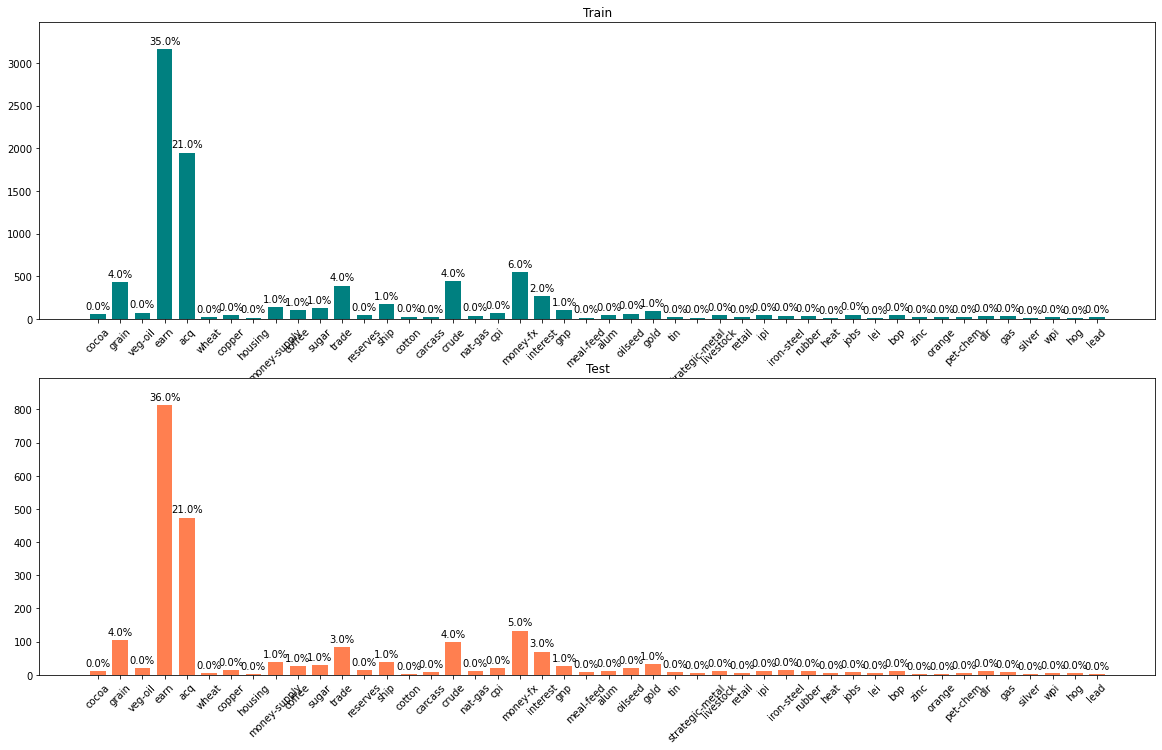

In [14]:
plot_distribution(train_labels, test_labels, params.classes)

![image-20201217123826241](images/image-20201217123826241.png)

### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

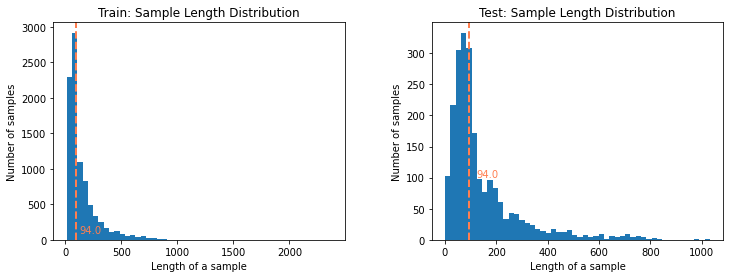

train：mean=144.54 variance=21261.74
test：mean=146.66 variance=21351.99


In [15]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))

![image-20210101163434402](images/image-20210101163434402.png)

通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [16]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,1211,550,225,99,70,30,27,25,9,2246
train,4834,2273,883,410,223,151,101,62,45,8982
合计,6045,2823,1108,509,293,181,128,87,54,11228


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,1209.215354,564.70057,221.639473,101.818133,58.610438,36.206448,25.60456,17.403099,10.801924,2246.0
train,4835.784646,2258.29943,886.360527,407.181867,234.389562,144.793552,102.39544,69.596901,43.198076,8982.0
合计,6045.000000,2823.00000,1108.000000,509.000000,293.000000,181.000000,128.00000,87.000000,54.000000,11228.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [17]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 9.355859347084184
critical_value = 15.50731305586545
p_value = 0.313170934470006


![image-20210101174317709](images/image-20210101174317709.png)

### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

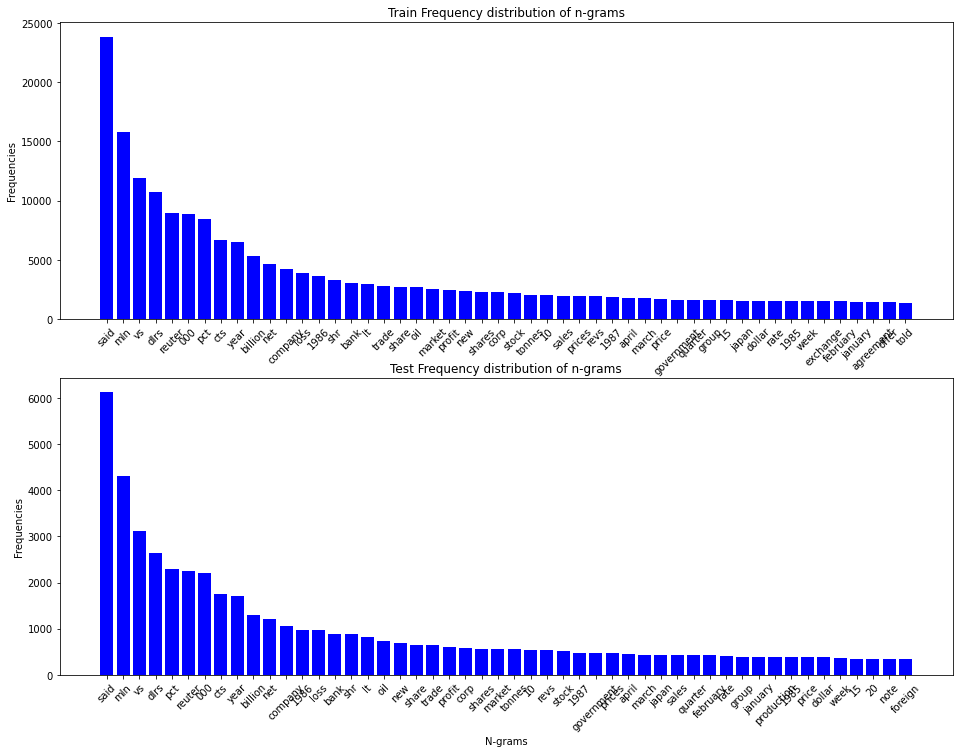

In [18]:
plot_frequency_distribution(train_texts, test_texts)

![image-20201217134151280](images/image-20201217134151280.png)

In [19]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 30978
Number of Vocabulary: 4676


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [20]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 95.6


![image-20201217144321430](images/image-20201217144321430.png)

可以看到这个比例大大小于143.7，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下两个过程。

- Tokenization：把文本转化成Token
- Vectorization： 把Token变成Vector

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [21]:
ngram_vectorizer = util.NgramVectorizer()
if params.use_stop_words:
    ngram_vectorizer.fit(train_texts, train_labels,
                         top_k=params.max_features, ngram_range=(1, 2),
                         stop_words=params.stop_words)
else:
    ngram_vectorizer.fit(train_texts, train_labels,
                         top_k=params.max_features, ngram_range=(1, 2),
                         stop_words=None)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1808: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


![image-20210102091446193](images/image-20210102091446193.png)

可以看到上面数据是以稀疏矩阵的形式存在的。下面创建ngram数据集。

In [22]:
ngram_datasets = SimpleTextDatasets(params, train_texts, train_labels, test_texts, test_labels, ngram_vectorizer)
                               
train_ngram = ngram_datasets.train_data
test_ngram = ngram_datasets.test_data
    
print(train_ngram.shape, type(train_ngram), train_ngram.dtype)
print(test_ngram.shape, type(test_ngram), test_ngram.dtype)
print(train_ngram[0, 0:1000])                               

save object to ./models/reuters/reuters_0329_p100/SimpleTextDatasets.vectorizer
create train, validation and test dataset
(8982, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
(2246, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 103)	0.08464232


### Sequence

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。下面将采用两种方式生成Sequence向量。

- Tokenizer
- TextVectorization

#### Tokenizer

In [23]:
sequence_vectorizer = util.SequenceVectorizer()
sequence_vectorizer.fit(train_texts, num_words=params.max_features, 
                        max_sequence_length =params.sequence_length)



创建sequence数据集。

In [24]:
sequence_datasets = SequenceTextDatasets(params, train_texts, train_labels, test_texts, test_labels, sequence_vectorizer)

train_seq = sequence_datasets.train_data
test_seq = sequence_datasets.test_data

print(train_seq.shape, type(train_seq), train_seq.dtype)
print(test_seq.shape, type(test_seq), test_seq.dtype)
print(test_seq[1][0:500])

save object to ./models/reuters/reuters_0329_p100/SequenceTextDatasets.vectorizer
create train, validation and test dataset
(8982, 500) <class 'numpy.ndarray'> int32
(2246, 500) <class 'numpy.ndarray'> int32
[ 1046    34   404     4  1290    10    56   796   821  1320   415  8599
   212     2   583    22  1866   123   239    71     6     7   232   150
   109   569   265    10     1    83   190     4    51    70  2150     3
   163  6528  5537   209   544     1   163    34   961  2449 19339     1
    62   600    76     1    73  4014    30     5    42   112    18  1632
   105   530    10   235   569    87    46   787   161   729   537   758
   102   338   534   927   275     1   333    47  2022  6632   235   245
    71 11675     5   720   239    28   533   596  4142    10  1717    74
    68    17  1717    44   654 11675     5    71    50  5027    68   139
     2  1087   448     1 14028     9   363     3   491   109    87    46
   105   995  1321   329   357    26     1   123    58    30  



##  模型

### MLP

In [25]:
def sparse_to_dense(value):
    if isinstance(value, tf.sparse.SparseTensor):
        return tf.sparse.to_dense(value)
    return value

def get_mlp(helper, dropout=None, name='mlp'):
    """Creates an instance of a multi-layer perceptron model"""
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    layer_count = helper.get_model_param(name, 'layer_count')
    units = helper.get_model_param(name, 'units')    
    
    input = layers.Input(shape=helper.datasets.input_shape)    
    x = tf.keras.layers.Lambda(sparse_to_dense)(input)
    if dropout>0: x = layers.Dropout(dropout)(x)
        
    for _ in range(layer_count):
        x = layers.Dense(units, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name)     
    helper.compile(model)   
    return model

helper = TextClassificationHelper(params, model_results=model_results, datasets=ngram_datasets)
model = get_mlp(helper)
model.summary()

model_params.mlp.dropout=0.6
model_params.mlp.layer_count=1
model_params.mlp.units=256
learning_rate=0.001
checkpoint_path=./models/reuters/reuters_0329_p100/mlp
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 20000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (Non

2021-03-30 14:55:12,280: INFO: start training


model_params.mlp.epochs=120
use ModelCheckpoint(filepath=./models/reuters/reuters_0329_p100/mlp, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/120
274/281 [============================>.] - ETA: 0s - loss: 2.1309 - accuracy: 0.5074 - sparse_top_k_categorical_accuracy: 0.6286WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-03-30 14:55:14,672: WARNING: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-03-30 14:55:14,691: WARNING: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:15,328: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 9ms/step - loss: 2.1153 - accuracy: 0.5105 - sparse_top_k_categorical_accuracy: 0.6313 - val_loss: 1.4185 - val_accuracy: 0.6772 - val_sparse_top_k_categorical_accuracy: 0.7502
Epoch 2/120
273/281 [============================>.] - ETA: 0s - loss: 1.2695 - accuracy: 0.7102 - sparse_top_k_categorical_accuracy: 0.7935INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:17,495: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 1.2696 - accuracy: 0.7096 - sparse_top_k_categorical_accuracy: 0.7933 - val_loss: 1.1040 - val_accuracy: 0.7529 - val_sparse_top_k_categorical_accuracy: 0.8290
Epoch 3/120
278/281 [============================>.] - ETA: 0s - loss: 1.0079 - accuracy: 0.7657 - sparse_top_k_categorical_accuracy: 0.8475INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:19,646: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 1.0078 - accuracy: 0.7656 - sparse_top_k_categorical_accuracy: 0.8476 - val_loss: 0.9447 - val_accuracy: 0.7827 - val_sparse_top_k_categorical_accuracy: 0.8575
Epoch 4/120
276/281 [============================>.] - ETA: 0s - loss: 0.8602 - accuracy: 0.8005 - sparse_top_k_categorical_accuracy: 0.8790INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:22,001: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 0.8579 - accuracy: 0.8010 - sparse_top_k_categorical_accuracy: 0.8791 - val_loss: 0.8533 - val_accuracy: 0.7956 - val_sparse_top_k_categorical_accuracy: 0.8820
Epoch 5/120
275/281 [============================>.] - ETA: 0s - loss: 0.7624 - accuracy: 0.8203 - sparse_top_k_categorical_accuracy: 0.8991INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:24,165: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 0.7606 - accuracy: 0.8212 - sparse_top_k_categorical_accuracy: 0.8994 - val_loss: 0.7971 - val_accuracy: 0.8050 - val_sparse_top_k_categorical_accuracy: 0.8909
Epoch 6/120
279/281 [============================>.] - ETA: 0s - loss: 0.6797 - accuracy: 0.8375 - sparse_top_k_categorical_accuracy: 0.9139INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:26,349: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 0.6802 - accuracy: 0.8372 - sparse_top_k_categorical_accuracy: 0.9139 - val_loss: 0.7650 - val_accuracy: 0.8157 - val_sparse_top_k_categorical_accuracy: 0.8949
Epoch 7/120
280/281 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.8489 - sparse_top_k_categorical_accuracy: 0.9253INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:28,495: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 0.6209 - accuracy: 0.8488 - sparse_top_k_categorical_accuracy: 0.9254 - val_loss: 0.7377 - val_accuracy: 0.8219 - val_sparse_top_k_categorical_accuracy: 0.8994
Epoch 8/120
276/281 [============================>.] - ETA: 0s - loss: 0.5676 - accuracy: 0.8630 - sparse_top_k_categorical_accuracy: 0.9385INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:30,661: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 0.5681 - accuracy: 0.8628 - sparse_top_k_categorical_accuracy: 0.9382 - val_loss: 0.7226 - val_accuracy: 0.8255 - val_sparse_top_k_categorical_accuracy: 0.9056
Epoch 9/120
281/281 [==============================] - 1s 5ms/step - loss: 0.5153 - accuracy: 0.8716 - sparse_top_k_categorical_accuracy: 0.9443 - val_loss: 0.7156 - val_accuracy: 0.8255 - val_sparse_top_k_categorical_accuracy: 0.9047
Epoch 10/120
277/281 [============================>.] - ETA: 0s - loss: 0.4853 - accuracy: 0.8805 - sparse_top_k_categorical_accuracy: 0.9490INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:34,168: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 0.4882 - accuracy: 0.8796 - sparse_top_k_categorical_accuracy: 0.9485 - val_loss: 0.7159 - val_accuracy: 0.8268 - val_sparse_top_k_categorical_accuracy: 0.9043
Epoch 11/120
281/281 [==============================] - 1s 5ms/step - loss: 0.4697 - accuracy: 0.8834 - sparse_top_k_categorical_accuracy: 0.9513 - val_loss: 0.7205 - val_accuracy: 0.8264 - val_sparse_top_k_categorical_accuracy: 0.9052
Epoch 12/120
271/281 [===========================>..] - ETA: 0s - loss: 0.4396 - accuracy: 0.8883 - sparse_top_k_categorical_accuracy: 0.9554INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:37,692: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 0.4379 - accuracy: 0.8888 - sparse_top_k_categorical_accuracy: 0.9557 - val_loss: 0.7187 - val_accuracy: 0.8281 - val_sparse_top_k_categorical_accuracy: 0.9065
Epoch 13/120
281/281 [==============================] - 1s 5ms/step - loss: 0.4177 - accuracy: 0.8903 - sparse_top_k_categorical_accuracy: 0.9587 - val_loss: 0.7299 - val_accuracy: 0.8277 - val_sparse_top_k_categorical_accuracy: 0.9078
Epoch 14/120
281/281 [==============================] - 1s 5ms/step - loss: 0.3990 - accuracy: 0.8960 - sparse_top_k_categorical_accuracy: 0.9605 - val_loss: 0.7364 - val_accuracy: 0.8281 - val_sparse_top_k_categorical_accuracy: 0.9043
Epoch 15/120
278/281 [============================>.] - ETA: 0s - loss: 0.3901 - accuracy: 0.8991 - sparse_top_k_categorical_accuracy: 0.9658INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:42,824: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 0.3888 - accuracy: 0.8994 - sparse_top_k_categorical_accuracy: 0.9659 - val_loss: 0.7333 - val_accuracy: 0.8304 - val_sparse_top_k_categorical_accuracy: 0.9069
Epoch 16/120
281/281 [==============================] - 1s 5ms/step - loss: 0.3659 - accuracy: 0.9021 - sparse_top_k_categorical_accuracy: 0.9666 - val_loss: 0.7464 - val_accuracy: 0.8286 - val_sparse_top_k_categorical_accuracy: 0.9078
Epoch 17/120
281/281 [==============================] - 1s 5ms/step - loss: 0.3572 - accuracy: 0.9035 - sparse_top_k_categorical_accuracy: 0.9670 - val_loss: 0.7504 - val_accuracy: 0.8268 - val_sparse_top_k_categorical_accuracy: 0.9092
Epoch 18/120
272/281 [============================>.] - ETA: 0s - loss: 0.3437 - accuracy: 0.9067 - sparse_top_k_categorical_accuracy: 0.9699INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


2021-03-30 14:55:47,739: INFO: Assets written to: ./models/reuters/reuters_0329_p100/mlp/assets


281/281 [==============================] - 2s 8ms/step - loss: 0.3439 - accuracy: 0.9067 - sparse_top_k_categorical_accuracy: 0.9696 - val_loss: 0.7550 - val_accuracy: 0.8313 - val_sparse_top_k_categorical_accuracy: 0.9061
Epoch 19/120
281/281 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.9099 - sparse_top_k_categorical_accuracy: 0.9695 - val_loss: 0.7624 - val_accuracy: 0.8313 - val_sparse_top_k_categorical_accuracy: 0.9047
Epoch 20/120
281/281 [==============================] - 1s 5ms/step - loss: 0.3281 - accuracy: 0.9060 - sparse_top_k_categorical_accuracy: 0.9729 - val_loss: 0.7719 - val_accuracy: 0.8286 - val_sparse_top_k_categorical_accuracy: 0.9043
Epoch 21/120
281/281 [==============================] - 1s 5ms/step - loss: 0.3244 - accuracy: 0.9134 - sparse_top_k_categorical_accuracy: 0.9725 - val_loss: 0.7923 - val_accuracy: 0.8272 - val_sparse_top_k_categorical_accuracy: 0.9043
Epoch 22/120
281/281 [==============================] - 1s 5ms/step -

281/281 [==============================] - 1s 5ms/step - loss: 0.2514 - accuracy: 0.9262 - sparse_top_k_categorical_accuracy: 0.9814 - val_loss: 0.8741 - val_accuracy: 0.8241 - val_sparse_top_k_categorical_accuracy: 0.9047
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/120
281/281 [==============================] - 1s 5ms/step - loss: 0.2582 - accuracy: 0.9246 - sparse_top_k_categorical_accuracy: 0.9800 - val_loss: 0.8735 - val_accuracy: 0.8250 - val_sparse_top_k_categorical_accuracy: 0.9056
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/120
281/281 [==============================] - 1s 5ms/step - loss: 0.2460 - accuracy: 0.9295 - sparse_top_k_categorical_accuracy: 0.9820 - val_loss: 0.8763 - val_accuracy: 0.8241 - val_sparse_top_k_categorical_accuracy: 0.9052
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/120
281/281 [==============================] - 1s 5ms/step - loss: 0.2530 - accuracy: 0.9245 - sparse_top_k_ca

2021-03-30 14:56:43,268: INFO: finish training [elapsed time: 90.99 seconds]


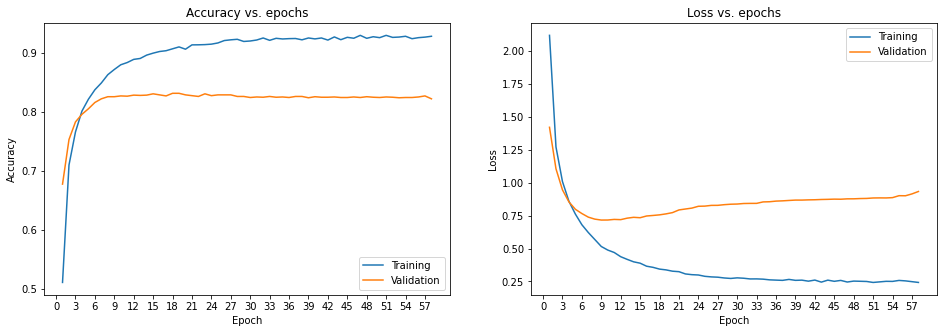

In [26]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/reuters/reuters_0329_p100/mlp
learning_rate=0.001
checkpoint_path=./models/reuters/reuters_0329_p100/mlp
71/71 [==============================] - 0s 3ms/step - loss: 0.7550 - accuracy: 0.8313 - sparse_top_k_categorical_accuracy: 0.9061
loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/reuters_0329_p100/mlp
loading load_vectorizer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/reuters_0329_p100/SimpleTextDatasets.vectorizer
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/reuters_0329_p100/mlp.predictor
Test loss:0.7550, Test Accuracy:83.13%
---------------------------------------- confusion matrix ----------------------------------------
71/71 [==============================] - 0s 2ms/step


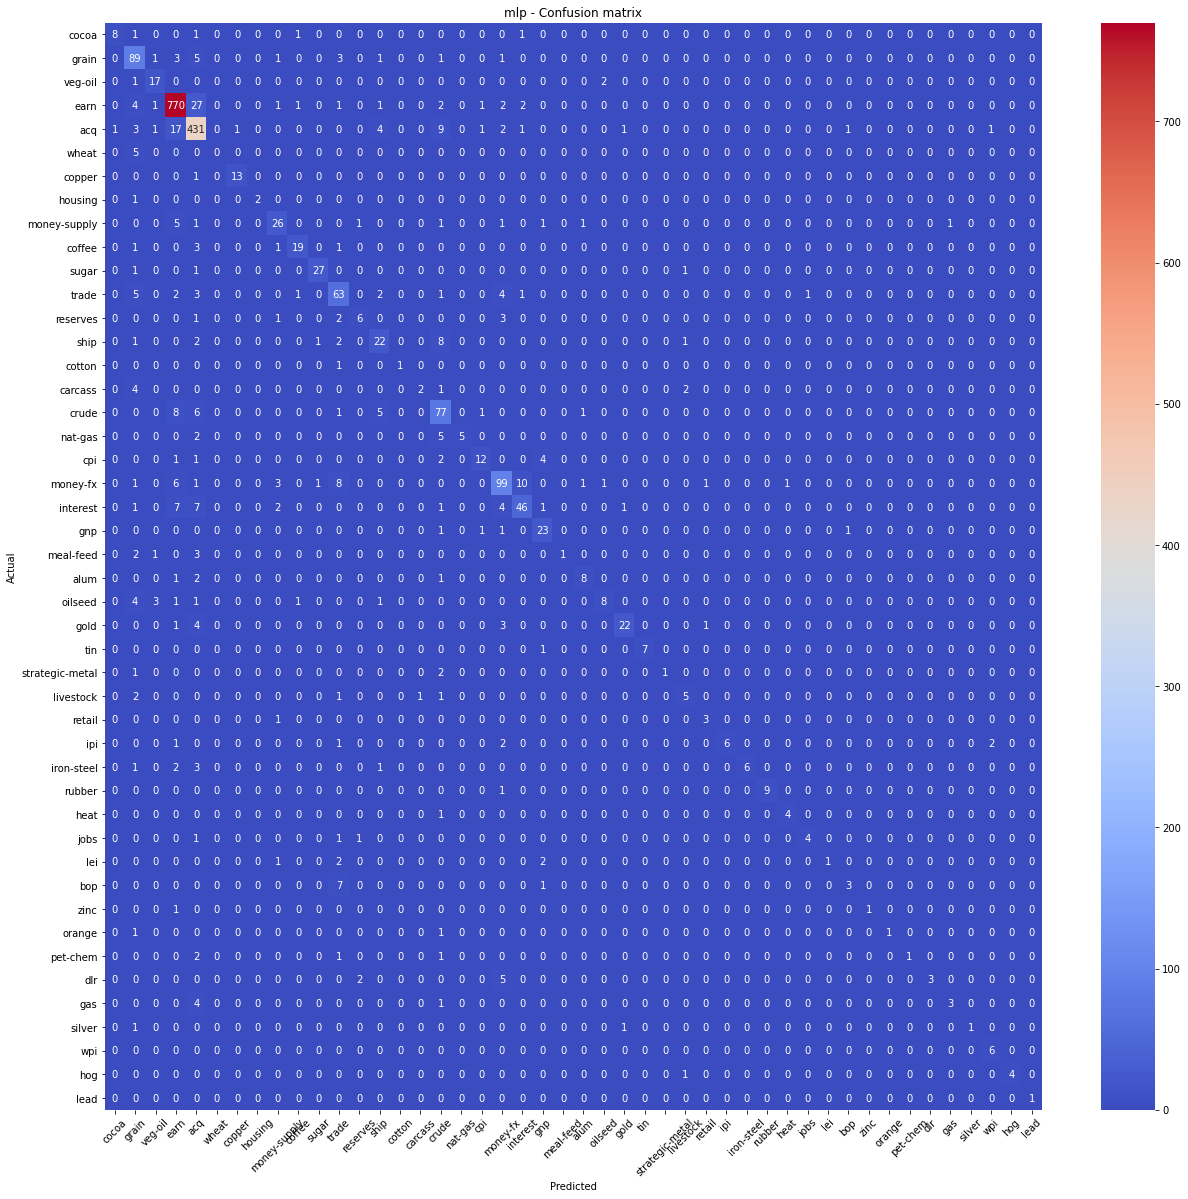

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,train_top2_accuracy,test_top2_accuracy,weight_number,train_time,predictor_path
mlp,0.190592,0.948,0.755008,0.8313,0.9699,0.9061,5132078,90.0,/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/5...


save json to ./models/reuters/reuters_0329_p100/model_results.json


In [27]:
helper.model_summary(model, history=history)

### Embedding

In [28]:
def get_embedding(helper,
                  dropout=None,
                  name='embedding'
                  is_embedding_trainable=False,
                  embedding_matrix=None,
                  mask_zero=True                  
                ):

    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')

    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 

    
#     model = models.Sequential(name=name)
#     model.add(layers.Embedding(input_dim=num_features,
#                                output_dim=embedding_dim,
#                                input_length=input_shape[0]))
#     model.add(layers.GlobalAveragePooling1D())
#     if dropout>0: model.add(layers.Dropout(rate=dropout))
#     model.add(layers.Dense(num_classes))

    input = layers.Input(shape=helper.datasets.input_shape)
    if embedding_matrix is None:
        x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim)(input)
    else:
        num_features, embedding_dim = embedding_matrix.shape
        x = layers.Embedding(input_dim=num_features+1,
                             output_dim=embedding_dim,
                             weights=[embedding_matrix],
                             trainable=is_embedding_trainable,
                             mask_zero=mask_zero
                            )(input)        
    x = layers.LSTM(units=units)(x)
#     x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
#     x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 

    helper.compile(model)  
    return model


helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_embedding(helper)
model.summary()

model_params.embedding.dropout=0.4
model_params.embedding.embedding_dim=200
learning_rate=0.001
checkpoint_path=./models/reuters/reuters_0329_p100/embedding
Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 200)          4000200   
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                9246      
Total params: 4,009,446
Trainable params: 4,009,446
Non-trainable params: 0
_________________________________________________________________


2021-03-30 14:56:59,342: INFO: start training


model_params.embedding.epochs=120
use ModelCheckpoint(filepath=./models/reuters/reuters_0329_p100/embedding, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/120
279/280 [============================>.] - ETA: 0s - loss: 2.5867 - accuracy: 0.3599 - sparse_top_k_categorical_accuracy: 0.6328INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:57:06,996: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 25ms/step - loss: 2.5864 - accuracy: 0.3595 - sparse_top_k_categorical_accuracy: 0.6324 - val_loss: 2.2433 - val_accuracy: 0.3816 - val_sparse_top_k_categorical_accuracy: 0.5806
Epoch 2/120
278/280 [============================>.] - ETA: 0s - loss: 2.1601 - accuracy: 0.4019 - sparse_top_k_categorical_accuracy: 0.5854INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:57:13,784: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 2.1617 - accuracy: 0.4013 - sparse_top_k_categorical_accuracy: 0.5849 - val_loss: 2.0684 - val_accuracy: 0.4225 - val_sparse_top_k_categorical_accuracy: 0.5975
Epoch 3/120
280/280 [==============================] - ETA: 0s - loss: 1.9884 - accuracy: 0.4750 - sparse_top_k_categorical_accuracy: 0.6080INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:57:20,491: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 1.9884 - accuracy: 0.4750 - sparse_top_k_categorical_accuracy: 0.6080 - val_loss: 1.9134 - val_accuracy: 0.5254 - val_sparse_top_k_categorical_accuracy: 0.6291
Epoch 4/120
278/280 [============================>.] - ETA: 0s - loss: 1.8289 - accuracy: 0.5489 - sparse_top_k_categorical_accuracy: 0.6377INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:57:27,177: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 1.8295 - accuracy: 0.5489 - sparse_top_k_categorical_accuracy: 0.6373 - val_loss: 1.7798 - val_accuracy: 0.5882 - val_sparse_top_k_categorical_accuracy: 0.6532
Epoch 5/120
280/280 [==============================] - ETA: 0s - loss: 1.6888 - accuracy: 0.6016 - sparse_top_k_categorical_accuracy: 0.6709INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:57:33,917: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 1.6888 - accuracy: 0.6016 - sparse_top_k_categorical_accuracy: 0.6709 - val_loss: 1.6672 - val_accuracy: 0.6242 - val_sparse_top_k_categorical_accuracy: 0.6915
Epoch 6/120
279/280 [============================>.] - ETA: 0s - loss: 1.5717 - accuracy: 0.6375 - sparse_top_k_categorical_accuracy: 0.7060INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:57:40,663: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 1.5709 - accuracy: 0.6377 - sparse_top_k_categorical_accuracy: 0.7063 - val_loss: 1.5757 - val_accuracy: 0.6474 - val_sparse_top_k_categorical_accuracy: 0.7119
Epoch 7/120
278/280 [============================>.] - ETA: 0s - loss: 1.4672 - accuracy: 0.6646 - sparse_top_k_categorical_accuracy: 0.7290INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:57:47,278: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 1.4653 - accuracy: 0.6648 - sparse_top_k_categorical_accuracy: 0.7295 - val_loss: 1.4970 - val_accuracy: 0.6692 - val_sparse_top_k_categorical_accuracy: 0.7320
Epoch 8/120
279/280 [============================>.] - ETA: 0s - loss: 1.3765 - accuracy: 0.6847 - sparse_top_k_categorical_accuracy: 0.7538INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:57:53,990: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 1.3755 - accuracy: 0.6849 - sparse_top_k_categorical_accuracy: 0.7541 - val_loss: 1.4350 - val_accuracy: 0.6821 - val_sparse_top_k_categorical_accuracy: 0.7449
Epoch 9/120
280/280 [==============================] - ETA: 0s - loss: 1.2966 - accuracy: 0.7019 - sparse_top_k_categorical_accuracy: 0.7703INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:58:00,811: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 1.2966 - accuracy: 0.7019 - sparse_top_k_categorical_accuracy: 0.7703 - val_loss: 1.3813 - val_accuracy: 0.6955 - val_sparse_top_k_categorical_accuracy: 0.7614
Epoch 10/120
278/280 [============================>.] - ETA: 0s - loss: 1.2354 - accuracy: 0.7194 - sparse_top_k_categorical_accuracy: 0.7883INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:58:07,422: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 1.2340 - accuracy: 0.7200 - sparse_top_k_categorical_accuracy: 0.7887 - val_loss: 1.3316 - val_accuracy: 0.6986 - val_sparse_top_k_categorical_accuracy: 0.7671
Epoch 11/120
278/280 [============================>.] - ETA: 0s - loss: 1.1721 - accuracy: 0.7312 - sparse_top_k_categorical_accuracy: 0.8017INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:58:14,050: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 1.1704 - accuracy: 0.7318 - sparse_top_k_categorical_accuracy: 0.8021 - val_loss: 1.2907 - val_accuracy: 0.7110 - val_sparse_top_k_categorical_accuracy: 0.7774
Epoch 12/120
279/280 [============================>.] - ETA: 0s - loss: 1.1153 - accuracy: 0.7491 - sparse_top_k_categorical_accuracy: 0.8151INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:58:20,643: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 1.1150 - accuracy: 0.7491 - sparse_top_k_categorical_accuracy: 0.8152 - val_loss: 1.2520 - val_accuracy: 0.7155 - val_sparse_top_k_categorical_accuracy: 0.7912
Epoch 13/120
280/280 [==============================] - ETA: 0s - loss: 1.0632 - accuracy: 0.7656 - sparse_top_k_categorical_accuracy: 0.8268INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:58:27,315: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 1.0632 - accuracy: 0.7656 - sparse_top_k_categorical_accuracy: 0.8268 - val_loss: 1.2193 - val_accuracy: 0.7302 - val_sparse_top_k_categorical_accuracy: 0.8005
Epoch 14/120
279/280 [============================>.] - ETA: 0s - loss: 1.0143 - accuracy: 0.7763 - sparse_top_k_categorical_accuracy: 0.8371INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:58:33,945: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 1.0142 - accuracy: 0.7762 - sparse_top_k_categorical_accuracy: 0.8372 - val_loss: 1.1892 - val_accuracy: 0.7386 - val_sparse_top_k_categorical_accuracy: 0.8050
Epoch 15/120
278/280 [============================>.] - ETA: 0s - loss: 0.9727 - accuracy: 0.7860 - sparse_top_k_categorical_accuracy: 0.8455INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:58:40,544: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 0.9700 - accuracy: 0.7868 - sparse_top_k_categorical_accuracy: 0.8461 - val_loss: 1.1588 - val_accuracy: 0.7458 - val_sparse_top_k_categorical_accuracy: 0.8152
Epoch 16/120
280/280 [==============================] - ETA: 0s - loss: 0.9312 - accuracy: 0.7939 - sparse_top_k_categorical_accuracy: 0.8547INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:58:47,090: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 0.9312 - accuracy: 0.7939 - sparse_top_k_categorical_accuracy: 0.8547 - val_loss: 1.1370 - val_accuracy: 0.7551 - val_sparse_top_k_categorical_accuracy: 0.8250
Epoch 17/120
280/280 [==============================] - 6s 21ms/step - loss: 0.8935 - accuracy: 0.8041 - sparse_top_k_categorical_accuracy: 0.8638 - val_loss: 1.1109 - val_accuracy: 0.7533 - val_sparse_top_k_categorical_accuracy: 0.8259
Epoch 18/120
278/280 [============================>.] - ETA: 0s - loss: 0.8576 - accuracy: 0.8109 - sparse_top_k_categorical_accuracy: 0.8704INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:58:59,771: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.8570 - accuracy: 0.8109 - sparse_top_k_categorical_accuracy: 0.8704 - val_loss: 1.0897 - val_accuracy: 0.7631 - val_sparse_top_k_categorical_accuracy: 0.8384
Epoch 19/120
279/280 [============================>.] - ETA: 0s - loss: 0.8212 - accuracy: 0.8196 - sparse_top_k_categorical_accuracy: 0.8786INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:59:06,464: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.8227 - accuracy: 0.8193 - sparse_top_k_categorical_accuracy: 0.8781 - val_loss: 1.0692 - val_accuracy: 0.7654 - val_sparse_top_k_categorical_accuracy: 0.8424
Epoch 20/120
279/280 [============================>.] - ETA: 0s - loss: 0.7873 - accuracy: 0.8271 - sparse_top_k_categorical_accuracy: 0.8873INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:59:13,064: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 0.7875 - accuracy: 0.8269 - sparse_top_k_categorical_accuracy: 0.8873 - val_loss: 1.0552 - val_accuracy: 0.7720 - val_sparse_top_k_categorical_accuracy: 0.8464
Epoch 21/120
278/280 [============================>.] - ETA: 0s - loss: 0.7589 - accuracy: 0.8335 - sparse_top_k_categorical_accuracy: 0.8925INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:59:19,932: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.7581 - accuracy: 0.8334 - sparse_top_k_categorical_accuracy: 0.8927 - val_loss: 1.0352 - val_accuracy: 0.7760 - val_sparse_top_k_categorical_accuracy: 0.8526
Epoch 22/120
280/280 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.8405 - sparse_top_k_categorical_accuracy: 0.9007INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:59:26,539: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 0.7280 - accuracy: 0.8405 - sparse_top_k_categorical_accuracy: 0.9007 - val_loss: 1.0233 - val_accuracy: 0.7805 - val_sparse_top_k_categorical_accuracy: 0.8549
Epoch 23/120
279/280 [============================>.] - ETA: 0s - loss: 0.6984 - accuracy: 0.8496 - sparse_top_k_categorical_accuracy: 0.9083INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:59:33,147: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 0.6996 - accuracy: 0.8493 - sparse_top_k_categorical_accuracy: 0.9080 - val_loss: 1.0062 - val_accuracy: 0.7823 - val_sparse_top_k_categorical_accuracy: 0.8557
Epoch 24/120
279/280 [============================>.] - ETA: 0s - loss: 0.6703 - accuracy: 0.8546 - sparse_top_k_categorical_accuracy: 0.9113INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:59:39,837: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.6691 - accuracy: 0.8550 - sparse_top_k_categorical_accuracy: 0.9116 - val_loss: 0.9923 - val_accuracy: 0.7876 - val_sparse_top_k_categorical_accuracy: 0.8615
Epoch 25/120
280/280 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.8616 - sparse_top_k_categorical_accuracy: 0.9174INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:59:46,518: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.6483 - accuracy: 0.8616 - sparse_top_k_categorical_accuracy: 0.9174 - val_loss: 0.9811 - val_accuracy: 0.7912 - val_sparse_top_k_categorical_accuracy: 0.8633
Epoch 26/120
278/280 [============================>.] - ETA: 0s - loss: 0.6197 - accuracy: 0.8684 - sparse_top_k_categorical_accuracy: 0.9238INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:59:53,176: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.6192 - accuracy: 0.8682 - sparse_top_k_categorical_accuracy: 0.9238 - val_loss: 0.9705 - val_accuracy: 0.7956 - val_sparse_top_k_categorical_accuracy: 0.8695
Epoch 27/120
278/280 [============================>.] - ETA: 0s - loss: 0.5965 - accuracy: 0.8751 - sparse_top_k_categorical_accuracy: 0.9285INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 14:59:59,780: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 0.5968 - accuracy: 0.8750 - sparse_top_k_categorical_accuracy: 0.9283 - val_loss: 0.9623 - val_accuracy: 0.7996 - val_sparse_top_k_categorical_accuracy: 0.8740
Epoch 28/120
280/280 [==============================] - ETA: 0s - loss: 0.5719 - accuracy: 0.8772 - sparse_top_k_categorical_accuracy: 0.9324INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 15:00:06,617: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.5719 - accuracy: 0.8772 - sparse_top_k_categorical_accuracy: 0.9324 - val_loss: 0.9529 - val_accuracy: 0.8014 - val_sparse_top_k_categorical_accuracy: 0.8744
Epoch 29/120
279/280 [============================>.] - ETA: 0s - loss: 0.5533 - accuracy: 0.8836 - sparse_top_k_categorical_accuracy: 0.9339INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 15:00:13,385: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.5528 - accuracy: 0.8837 - sparse_top_k_categorical_accuracy: 0.9340 - val_loss: 0.9442 - val_accuracy: 0.8023 - val_sparse_top_k_categorical_accuracy: 0.8780
Epoch 30/120
280/280 [==============================] - 6s 22ms/step - loss: 0.5269 - accuracy: 0.8869 - sparse_top_k_categorical_accuracy: 0.9404 - val_loss: 0.9377 - val_accuracy: 0.8010 - val_sparse_top_k_categorical_accuracy: 0.8771
Epoch 31/120
280/280 [==============================] - 6s 21ms/step - loss: 0.5105 - accuracy: 0.8926 - sparse_top_k_categorical_accuracy: 0.9439 - val_loss: 0.9325 - val_accuracy: 0.8023 - val_sparse_top_k_categorical_accuracy: 0.8798
Epoch 32/120
280/280 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.8942 - sparse_top_k_categorical_accuracy: 0.9459INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 15:00:32,103: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 23ms/step - loss: 0.4912 - accuracy: 0.8942 - sparse_top_k_categorical_accuracy: 0.9459 - val_loss: 0.9273 - val_accuracy: 0.8041 - val_sparse_top_k_categorical_accuracy: 0.8807
Epoch 33/120
280/280 [==============================] - 6s 22ms/step - loss: 0.4715 - accuracy: 0.8984 - sparse_top_k_categorical_accuracy: 0.9502 - val_loss: 0.9213 - val_accuracy: 0.8019 - val_sparse_top_k_categorical_accuracy: 0.8825
Epoch 34/120
280/280 [==============================] - 6s 21ms/step - loss: 0.4511 - accuracy: 0.9036 - sparse_top_k_categorical_accuracy: 0.9541 - val_loss: 0.9184 - val_accuracy: 0.8014 - val_sparse_top_k_categorical_accuracy: 0.8829
Epoch 35/120
278/280 [============================>.] - ETA: 0s - loss: 0.4355 - accuracy: 0.9085 - sparse_top_k_categorical_accuracy: 0.9556INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 15:00:51,128: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.4362 - accuracy: 0.9081 - sparse_top_k_categorical_accuracy: 0.9552 - val_loss: 0.9149 - val_accuracy: 0.8054 - val_sparse_top_k_categorical_accuracy: 0.8856
Epoch 36/120
280/280 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.9106 - sparse_top_k_categorical_accuracy: 0.9584INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 15:00:57,844: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.4190 - accuracy: 0.9106 - sparse_top_k_categorical_accuracy: 0.9584 - val_loss: 0.9103 - val_accuracy: 0.8063 - val_sparse_top_k_categorical_accuracy: 0.8874
Epoch 37/120
278/280 [============================>.] - ETA: 0s - loss: 0.4056 - accuracy: 0.9125 - sparse_top_k_categorical_accuracy: 0.9593INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


2021-03-30 15:01:04,502: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.4045 - accuracy: 0.9128 - sparse_top_k_categorical_accuracy: 0.9595 - val_loss: 0.9118 - val_accuracy: 0.8085 - val_sparse_top_k_categorical_accuracy: 0.8878
Epoch 38/120
280/280 [==============================] - 6s 21ms/step - loss: 0.3917 - accuracy: 0.9163 - sparse_top_k_categorical_accuracy: 0.9616 - val_loss: 0.9113 - val_accuracy: 0.8068 - val_sparse_top_k_categorical_accuracy: 0.8878
Epoch 39/120
280/280 [==============================] - 6s 21ms/step - loss: 0.3741 - accuracy: 0.9215 - sparse_top_k_categorical_accuracy: 0.9657 - val_loss: 0.9096 - val_accuracy: 0.8050 - val_sparse_top_k_categorical_accuracy: 0.8869
Epoch 40/120
280/280 [==============================] - 6s 21ms/step - loss: 0.3645 - accuracy: 0.9222 - sparse_top_k_categorical_accuracy: 0.9661 - val_loss: 0.9071 - val_accuracy: 0.8072 - val_sparse_top_k_categorical_accuracy: 0.8896
Epoch 41/120
280/280 [==============================] - ETA: 0s -

2021-03-30 15:01:29,207: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.3554 - accuracy: 0.9233 - sparse_top_k_categorical_accuracy: 0.9663 - val_loss: 0.9070 - val_accuracy: 0.8117 - val_sparse_top_k_categorical_accuracy: 0.8909
Epoch 42/120
280/280 [==============================] - 6s 22ms/step - loss: 0.3383 - accuracy: 0.9283 - sparse_top_k_categorical_accuracy: 0.9702 - val_loss: 0.9066 - val_accuracy: 0.8094 - val_sparse_top_k_categorical_accuracy: 0.8905
Epoch 43/120
280/280 [==============================] - 6s 22ms/step - loss: 0.3292 - accuracy: 0.9290 - sparse_top_k_categorical_accuracy: 0.9717 - val_loss: 0.9088 - val_accuracy: 0.8117 - val_sparse_top_k_categorical_accuracy: 0.8923
Epoch 44/120
280/280 [==============================] - 6s 21ms/step - loss: 0.3199 - accuracy: 0.9291 - sparse_top_k_categorical_accuracy: 0.9723 - val_loss: 0.9093 - val_accuracy: 0.8117 - val_sparse_top_k_categorical_accuracy: 0.8945
Epoch 45/120
280/280 [==============================] - 6s 21ms/s

2021-03-30 15:02:12,398: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.2805 - accuracy: 0.9371 - sparse_top_k_categorical_accuracy: 0.9788 - val_loss: 0.9171 - val_accuracy: 0.8126 - val_sparse_top_k_categorical_accuracy: 0.8940
Epoch 49/120
280/280 [==============================] - 6s 21ms/step - loss: 0.2718 - accuracy: 0.9392 - sparse_top_k_categorical_accuracy: 0.9785 - val_loss: 0.9178 - val_accuracy: 0.8112 - val_sparse_top_k_categorical_accuracy: 0.8954
Epoch 50/120
280/280 [==============================] - 6s 22ms/step - loss: 0.2658 - accuracy: 0.9391 - sparse_top_k_categorical_accuracy: 0.9801 - val_loss: 0.9209 - val_accuracy: 0.8112 - val_sparse_top_k_categorical_accuracy: 0.8963
Epoch 51/120
280/280 [==============================] - 6s 22ms/step - loss: 0.2603 - accuracy: 0.9393 - sparse_top_k_categorical_accuracy: 0.9815 - val_loss: 0.9248 - val_accuracy: 0.8081 - val_sparse_top_k_categorical_accuracy: 0.8927
Epoch 52/120
280/280 [==============================] - 6s 22ms/s

2021-03-30 15:02:55,592: INFO: Assets written to: ./models/reuters/reuters_0329_p100/embedding/assets


280/280 [==============================] - 7s 24ms/step - loss: 0.2325 - accuracy: 0.9443 - sparse_top_k_categorical_accuracy: 0.9846 - val_loss: 0.9351 - val_accuracy: 0.8130 - val_sparse_top_k_categorical_accuracy: 0.8958
Epoch 56/120
280/280 [==============================] - 6s 22ms/step - loss: 0.2269 - accuracy: 0.9454 - sparse_top_k_categorical_accuracy: 0.9850 - val_loss: 0.9471 - val_accuracy: 0.8103 - val_sparse_top_k_categorical_accuracy: 0.8923
Epoch 57/120
279/280 [============================>.] - ETA: 0s - loss: 0.2216 - accuracy: 0.9474 - sparse_top_k_categorical_accuracy: 0.9854
Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
280/280 [==============================] - 6s 22ms/step - loss: 0.2210 - accuracy: 0.9474 - sparse_top_k_categorical_accuracy: 0.9855 - val_loss: 0.9545 - val_accuracy: 0.8090 - val_sparse_top_k_categorical_accuracy: 0.8914
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/120
280/280 [=====

Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 84/120
280/280 [==============================] - 6s 21ms/step - loss: 0.1974 - accuracy: 0.9535 - sparse_top_k_categorical_accuracy: 0.9882 - val_loss: 0.9548 - val_accuracy: 0.8085 - val_sparse_top_k_categorical_accuracy: 0.8963
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/120
280/280 [==============================] - 6s 21ms/step - loss: 0.1960 - accuracy: 0.9523 - sparse_top_k_categorical_accuracy: 0.9875 - val_loss: 0.9550 - val_accuracy: 0.8094 - val_sparse_top_k_categorical_accuracy: 0.8972
Epoch 00086: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 86/120
280/280 [==============================] - 6s 21ms/step - loss: 0.1958 - accuracy: 0.9517 - sparse_top_k_categorical_accuracy: 0.9875 - val_loss: 0.9552 - val_accuracy: 0.8090 - val_sparse_top_k_categorical_accuracy: 0.8967
Epoch 00087: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 87/120
278/280 [=======

2021-03-30 15:06:57,563: INFO: finish training [elapsed time: 598.22 seconds]


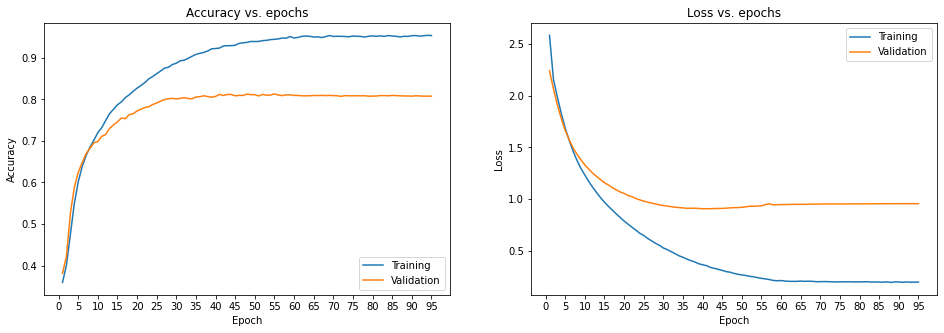

In [29]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/reuters/reuters_0329_p100/embedding
learning_rate=0.001
checkpoint_path=./models/reuters/reuters_0329_p100/embedding
71/71 [==============================] - 0s 4ms/step - loss: 0.9351 - accuracy: 0.8130 - sparse_top_k_categorical_accuracy: 0.8958
loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/reuters_0329_p100/embedding
loading load_vectorizer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/reuters_0329_p100/SequenceTextDatasets.vectorizer
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/reuters_0329_p100/embedding.predictor
Test loss:0.9351, Test Accuracy:81.30%
---------------------------------------- confusion matrix ----------------------------------------
71/71 [==============================] - 0s 3ms/step


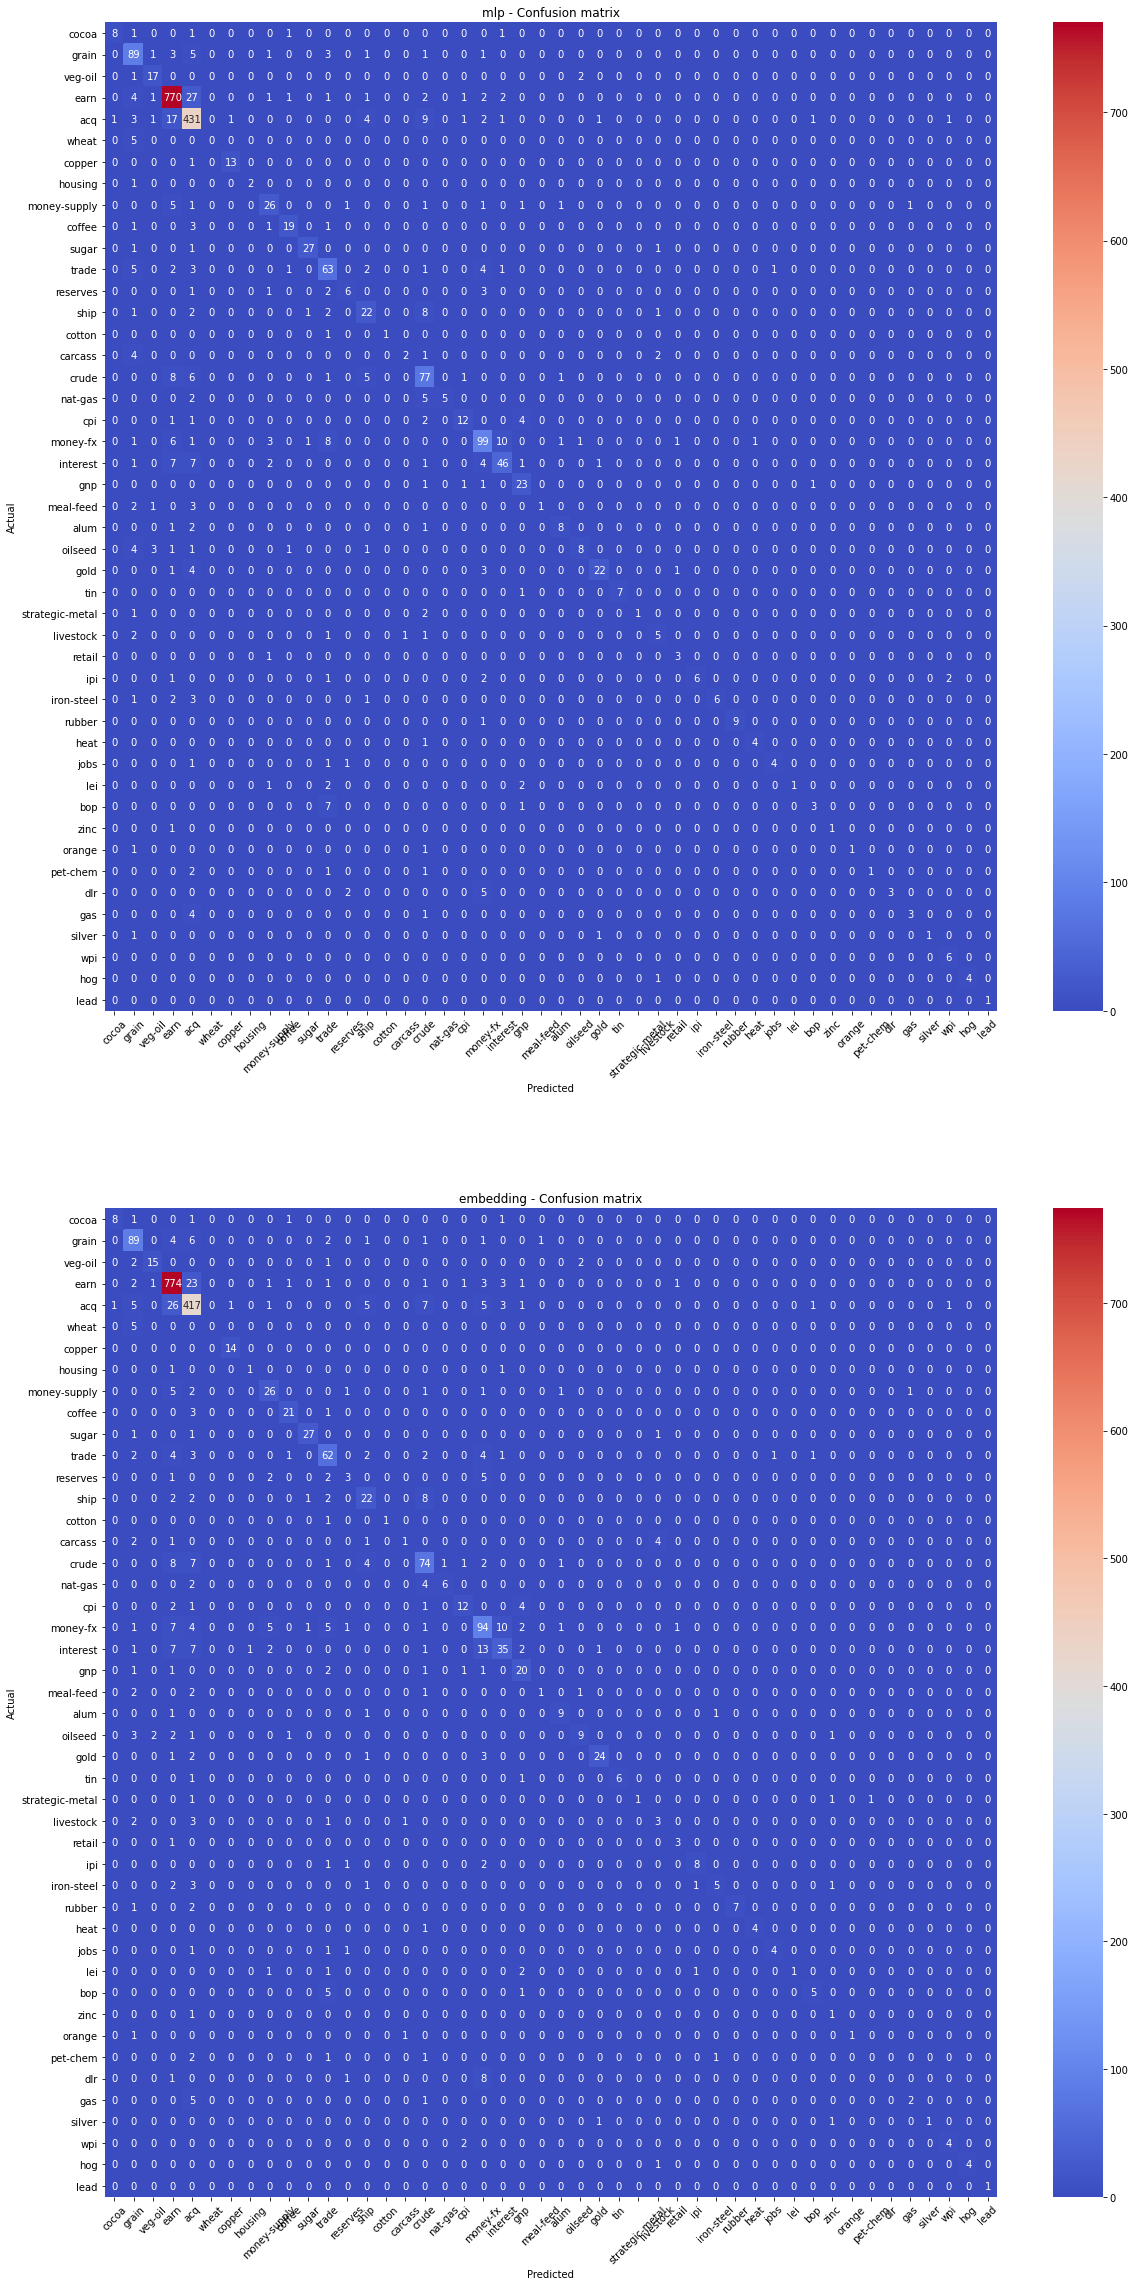

---------------------------------------- error analysis ----------------------------------------
71/71 [==============================] - 0s 3ms/step
........................................ crude ........................................
oper shr 70 cts vs 18 cts oper net 39 1 mln vs 10 0 mln sales 543 6 mln vs 489 6 mln year oper shr 2 83 dlrs vs 1 82 dlrs oper net 159 7 mln vs 106 9 mln sales 2 13 billion vs 1 94 billion avg shrs 56 4 mln vs 58 6 mln note results restated for discontinued engineering services operations prior year net excludes losses from discontinued operations of 143 000 dlrs in quarter and 102 156 dlrs in year fiscal 1987 year net excludes 4 081 000 dlr charge from early debt retirement fiscal 1986 net includes special charges 24 7 mln dlrs in quarter and 37 2 mln dlrs in year from worgroce reduction costs revaluation of south african investment reversal of investment tax credits and othe4r items reuter 3


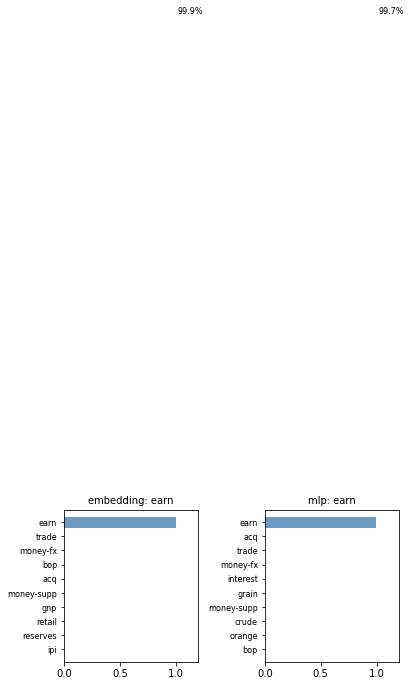

........................................ acq ........................................
china will have a budget deficit of 8 017 billion yuan in calendar 1987 compared with a 7 08 billion deficit in 1986 finance minister wang bingqian said he told the national people's congress the state council has decided to cut nearly all 1987 budgetary expenditures by 10 pct from the 1986 level he said expenditures for the past two years have been inflated investment by localities in capital construction in 1987 must fall by 50 pct from the 1986 level and state firms must cut their losses by 30 pct he said china will use 14 6 billion yuan in foreign loans in 1987 up from 7 87 billion in 1986 wang said it must cut back on investment in capital construction especially construction outside the state plan he said funds must go into energy transport telecommunications raw and semi finished materials and not into non production sectors in view of the country's financial difficulties this year it has been 

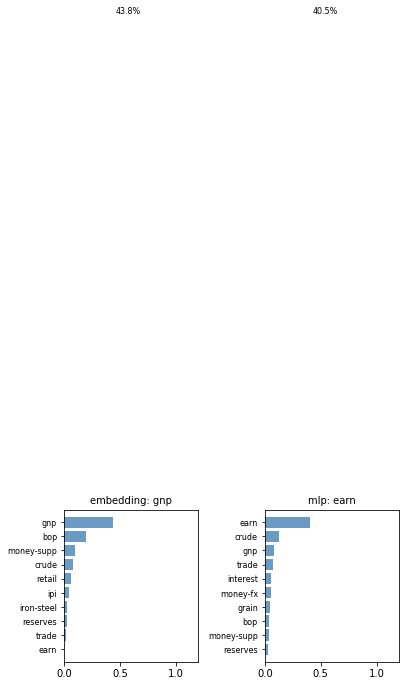

........................................ trade ........................................
summit petroleum corp said it sold 11 3 mln shares or 29 4 pct of its common stock to lt halbert and associates inc the company said the shares were previously held by lt consolidated energy corp and harken oil and gas inc lt hogi in addition david d halbert president and chief executive officer of halbert an abilene investment firm was named chairman and chief executive of summit the company said halbert charles m bruce and james o burke were also named directors expanding the board to five summit added the company said burke is president and chief executive of lt allied comprehensive health inc abilene while bruce is a partner in the washington law firm of butler and binion summit said it intends to actively seek acquisitions to increase its asset base reuter 3


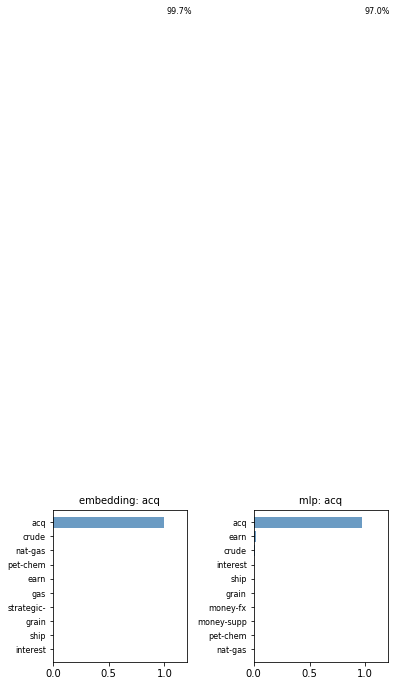

........................................ oilseed ........................................
argentine subproducts shipments during january december 1986 totalled 5 618 315 tonnes against 4 815 188 tonnes in the same period of 1985 the argentine grain board said breakdown was as follows cotton 26 992 41 933 sunflower 1 403 230 1 190 862 linseed 261 600 309 191 groundnutseed 23 595 22 809 soybean 3 275 225 2 415 492 bran pollards wheat 606 352 659 271 fiber cotton 3 256 107 752 wheat flour 18 065 67 878 rape nil nil the board added shipments during december 1986 amounted to 418 755 tonnes against 257 844 tonnes in the same month of 1985 the breakdown was as follows in tonnes cotton 3 002 6 234 sunflower 86 612 38 347 linseed 23 954 38 290 groundnutseed nil nil soybean 264 650 104 571 bran polards wheat 37 724 49 946 fiber cotton 987 2 121 wheat flour 1 826 18 335 rapeseed nil nil the board said the ten principal destinations during january december 1986 with comparative figures for the sam

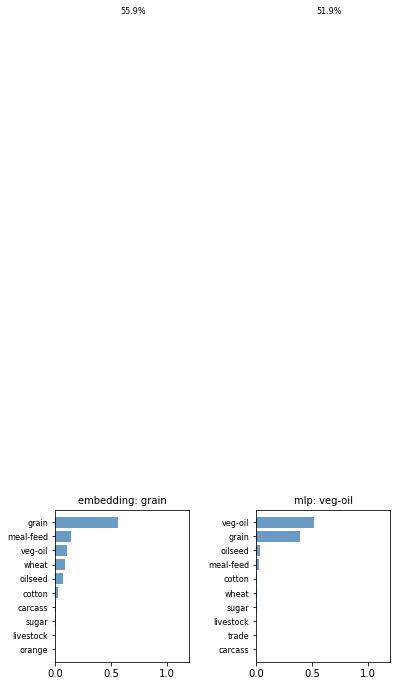

........................................ livestock ........................................
united food and commercial workers union local 222 rejected a new contract proposal from iowa beef processors inc and remain out of work union spokesman allen zack said in mid december iowa beef a subsidiary of occidental petroleum corp closed its beef processing plant at dakota city nebraska because it said it had no alternative to threats by meatpackers to disrupt operations about 2 800 ufcwu members are affected by what the union terms as a lockout a 3 1 2 year labor contract at the plant expired december 13 zack said ibp's proposal included elimination of a two tier wage structure a 60 cent an hour wage cut for slaughterers and a 45 cent an hour wage reduction for processors the new proposal also included a bonus system of 1 000 dlrs for workers who had been at the plant for two years zack said the annual turnover rate at the facility is 100 pct he said reuter 3


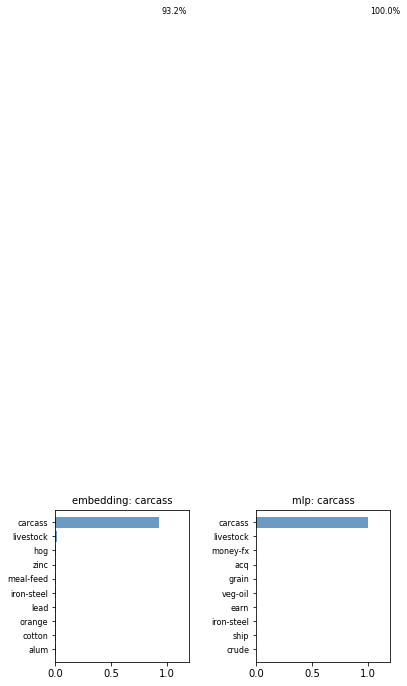

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,train_top2_accuracy,test_top2_accuracy,weight_number,train_time,predictor_path
mlp,0.190592,0.9480,0.755008,0.8313,0.9699,0.9061,5132078,90.0,/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/5...
embedding,0.210741,0.9494,0.935111,0.8130,0.9681,0.8958,4009446,598.0,/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/5...


save json to ./models/reuters/reuters_0329_p100/model_results.json


In [30]:
helper.model_summary(model, history=history)

### sepCNN

In [33]:
def get_sepcnn(helper,
                 blocks=1,
                 filters=64,
                 kernel_size=3,
                 embedding_dim=200,
                 dropout=None,
                 pool_size=3,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None, 
                 mask_zero=True,
                 name='sepcnn'
                ):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
        
    input_shape = helper.datasets.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   weights=[embedding_matrix],
                                   trainable=is_embedding_trainable, 
                                   mask_zero=mask_zero))
    else:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0]))

    for i in range(blocks):
        model.add(layers.Dropout(rate=dropout))
        if i==blocks-1: filters=filters*2
        model.add(layers.SeparableConv1D(filters=filters,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.SeparableConv1D(filters=filters,     
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.MaxPooling1D(pool_size=pool_size))

    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(num_classes))
    helper.compile(model)  
    return model


helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_sepcnn(helper, blocks=1)
# when bolcks=2, the model can't converg
model.summary()

model_params.sepcnn.dropout=0.4
learning_rate=0.001
checkpoint_path=./models/reuters/reuters_0329_p100/sepcnn
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 500, 128)          26328     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 128)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
________________

2021-03-30 15:27:07,480: INFO: start training


model_params.sepcnn.epochs=60
use ModelCheckpoint(filepath=./models/reuters/reuters_0329_p100/sepcnn, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/60
279/280 [============================>.] - ETA: 0s - loss: 2.5972 - accuracy: 0.3395 - sparse_top_k_categorical_accuracy: 0.6204INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:27:17,923: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 9s 31ms/step - loss: 2.5967 - accuracy: 0.3394 - sparse_top_k_categorical_accuracy: 0.6202 - val_loss: 2.1853 - val_accuracy: 0.3798 - val_sparse_top_k_categorical_accuracy: 0.6037
Epoch 2/60
280/280 [==============================] - ETA: 0s - loss: 1.9687 - accuracy: 0.4294 - sparse_top_k_categorical_accuracy: 0.6242INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:27:26,438: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 8s 30ms/step - loss: 1.9687 - accuracy: 0.4294 - sparse_top_k_categorical_accuracy: 0.6242 - val_loss: 1.8427 - val_accuracy: 0.5232 - val_sparse_top_k_categorical_accuracy: 0.6545
Epoch 3/60
279/280 [============================>.] - ETA: 0s - loss: 1.7720 - accuracy: 0.5538 - sparse_top_k_categorical_accuracy: 0.6605INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:27:34,934: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 8s 30ms/step - loss: 1.7723 - accuracy: 0.5537 - sparse_top_k_categorical_accuracy: 0.6606 - val_loss: 1.7017 - val_accuracy: 0.5864 - val_sparse_top_k_categorical_accuracy: 0.6785
Epoch 4/60
278/280 [============================>.] - ETA: 0s - loss: 1.6201 - accuracy: 0.6012 - sparse_top_k_categorical_accuracy: 0.6871INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:27:43,431: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 8s 30ms/step - loss: 1.6181 - accuracy: 0.6011 - sparse_top_k_categorical_accuracy: 0.6872 - val_loss: 1.6276 - val_accuracy: 0.6140 - val_sparse_top_k_categorical_accuracy: 0.6915
Epoch 5/60
280/280 [==============================] - ETA: 0s - loss: 1.4945 - accuracy: 0.6330 - sparse_top_k_categorical_accuracy: 0.7138INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:27:51,991: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 9s 30ms/step - loss: 1.4945 - accuracy: 0.6330 - sparse_top_k_categorical_accuracy: 0.7138 - val_loss: 1.5325 - val_accuracy: 0.6509 - val_sparse_top_k_categorical_accuracy: 0.7213
Epoch 6/60
279/280 [============================>.] - ETA: 0s - loss: 1.3466 - accuracy: 0.6785 - sparse_top_k_categorical_accuracy: 0.7488INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:28:00,888: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 9s 32ms/step - loss: 1.3464 - accuracy: 0.6787 - sparse_top_k_categorical_accuracy: 0.7489 - val_loss: 1.4169 - val_accuracy: 0.6785 - val_sparse_top_k_categorical_accuracy: 0.7471
Epoch 7/60
280/280 [==============================] - ETA: 0s - loss: 1.1898 - accuracy: 0.7096 - sparse_top_k_categorical_accuracy: 0.7801INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:28:09,446: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 9s 30ms/step - loss: 1.1898 - accuracy: 0.7096 - sparse_top_k_categorical_accuracy: 0.7801 - val_loss: 1.3822 - val_accuracy: 0.6928 - val_sparse_top_k_categorical_accuracy: 0.7729
Epoch 8/60
280/280 [==============================] - ETA: 0s - loss: 1.0832 - accuracy: 0.7352 - sparse_top_k_categorical_accuracy: 0.8076INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:28:17,953: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 8s 30ms/step - loss: 1.0832 - accuracy: 0.7352 - sparse_top_k_categorical_accuracy: 0.8076 - val_loss: 1.3198 - val_accuracy: 0.7128 - val_sparse_top_k_categorical_accuracy: 0.7903
Epoch 9/60
279/280 [============================>.] - ETA: 0s - loss: 0.9829 - accuracy: 0.7559 - sparse_top_k_categorical_accuracy: 0.8321INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:28:26,802: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 9s 31ms/step - loss: 0.9844 - accuracy: 0.7556 - sparse_top_k_categorical_accuracy: 0.8318 - val_loss: 1.3097 - val_accuracy: 0.7217 - val_sparse_top_k_categorical_accuracy: 0.8010
Epoch 10/60
280/280 [==============================] - ETA: 0s - loss: 0.9039 - accuracy: 0.7721 - sparse_top_k_categorical_accuracy: 0.8481INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:28:35,538: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 9s 31ms/step - loss: 0.9039 - accuracy: 0.7721 - sparse_top_k_categorical_accuracy: 0.8481 - val_loss: 1.3359 - val_accuracy: 0.7284 - val_sparse_top_k_categorical_accuracy: 0.8068
Epoch 11/60
279/280 [============================>.] - ETA: 0s - loss: 0.8349 - accuracy: 0.7873 - sparse_top_k_categorical_accuracy: 0.8583INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:28:44,173: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 9s 31ms/step - loss: 0.8349 - accuracy: 0.7873 - sparse_top_k_categorical_accuracy: 0.8584 - val_loss: 1.3352 - val_accuracy: 0.7289 - val_sparse_top_k_categorical_accuracy: 0.8121
Epoch 12/60
279/280 [============================>.] - ETA: 0s - loss: 0.7764 - accuracy: 0.8076 - sparse_top_k_categorical_accuracy: 0.8719INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:28:52,709: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 8s 30ms/step - loss: 0.7765 - accuracy: 0.8074 - sparse_top_k_categorical_accuracy: 0.8719 - val_loss: 1.3543 - val_accuracy: 0.7346 - val_sparse_top_k_categorical_accuracy: 0.8130
Epoch 13/60
280/280 [==============================] - 7s 27ms/step - loss: 0.7152 - accuracy: 0.8190 - sparse_top_k_categorical_accuracy: 0.8844 - val_loss: 1.4424 - val_accuracy: 0.7253 - val_sparse_top_k_categorical_accuracy: 0.8170
Epoch 14/60
280/280 [==============================] - 7s 26ms/step - loss: 0.6536 - accuracy: 0.8365 - sparse_top_k_categorical_accuracy: 0.9002 - val_loss: 1.4987 - val_accuracy: 0.7266 - val_sparse_top_k_categorical_accuracy: 0.8224
Epoch 15/60
280/280 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.8451 - sparse_top_k_categorical_accuracy: 0.9075INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:29:17,124: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 9s 34ms/step - loss: 0.6131 - accuracy: 0.8451 - sparse_top_k_categorical_accuracy: 0.9075 - val_loss: 1.5341 - val_accuracy: 0.7355 - val_sparse_top_k_categorical_accuracy: 0.8188
Epoch 16/60
280/280 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.8538 - sparse_top_k_categorical_accuracy: 0.9182INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:29:26,474: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 9s 33ms/step - loss: 0.5724 - accuracy: 0.8538 - sparse_top_k_categorical_accuracy: 0.9182 - val_loss: 1.5269 - val_accuracy: 0.7458 - val_sparse_top_k_categorical_accuracy: 0.8232
Epoch 17/60
280/280 [==============================] - 8s 29ms/step - loss: 0.5330 - accuracy: 0.8651 - sparse_top_k_categorical_accuracy: 0.9250 - val_loss: 1.5663 - val_accuracy: 0.7409 - val_sparse_top_k_categorical_accuracy: 0.8290
Epoch 18/60
280/280 [==============================] - 8s 29ms/step - loss: 0.5011 - accuracy: 0.8744 - sparse_top_k_categorical_accuracy: 0.9314 - val_loss: 1.6223 - val_accuracy: 0.7413 - val_sparse_top_k_categorical_accuracy: 0.8281
Epoch 19/60
280/280 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.8817 - sparse_top_k_categorical_accuracy: 0.9379INFO:tensorflow:Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


2021-03-30 15:29:52,100: INFO: Assets written to: ./models/reuters/reuters_0329_p100/sepcnn/assets


280/280 [==============================] - 9s 33ms/step - loss: 0.4778 - accuracy: 0.8817 - sparse_top_k_categorical_accuracy: 0.9379 - val_loss: 1.6555 - val_accuracy: 0.7480 - val_sparse_top_k_categorical_accuracy: 0.8339
Epoch 20/60
280/280 [==============================] - 8s 29ms/step - loss: 0.4536 - accuracy: 0.8887 - sparse_top_k_categorical_accuracy: 0.9449 - val_loss: 1.7632 - val_accuracy: 0.7467 - val_sparse_top_k_categorical_accuracy: 0.8330
Epoch 21/60
280/280 [==============================] - 8s 29ms/step - loss: 0.4209 - accuracy: 0.8993 - sparse_top_k_categorical_accuracy: 0.9507 - val_loss: 1.7875 - val_accuracy: 0.7391 - val_sparse_top_k_categorical_accuracy: 0.8286
Epoch 22/60
280/280 [==============================] - 8s 29ms/step - loss: 0.4047 - accuracy: 0.9016 - sparse_top_k_categorical_accuracy: 0.9513 - val_loss: 1.8107 - val_accuracy: 0.7480 - val_sparse_top_k_categorical_accuracy: 0.8353
Epoch 23/60
280/280 [==============================] - 8s 28ms/step 

280/280 [==============================] - 10s 34ms/step - loss: 0.2255 - accuracy: 0.9412 - sparse_top_k_categorical_accuracy: 0.9771 - val_loss: 2.3695 - val_accuracy: 0.7355 - val_sparse_top_k_categorical_accuracy: 0.8295
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/60
280/280 [==============================] - 10s 37ms/step - loss: 0.2328 - accuracy: 0.9419 - sparse_top_k_categorical_accuracy: 0.9771 - val_loss: 2.3731 - val_accuracy: 0.7351 - val_sparse_top_k_categorical_accuracy: 0.8299
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/60
280/280 [==============================] - 10s 36ms/step - loss: 0.2322 - accuracy: 0.9402 - sparse_top_k_categorical_accuracy: 0.9752 - val_loss: 2.3728 - val_accuracy: 0.7400 - val_sparse_top_k_categorical_accuracy: 0.8308
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/60
280/280 [==============================] - 9s 31ms/step - loss: 0.2160 - accuracy: 0.9440 - sparse_top_

2021-03-30 15:36:03,506: INFO: finish training [elapsed time: 536.03 seconds]


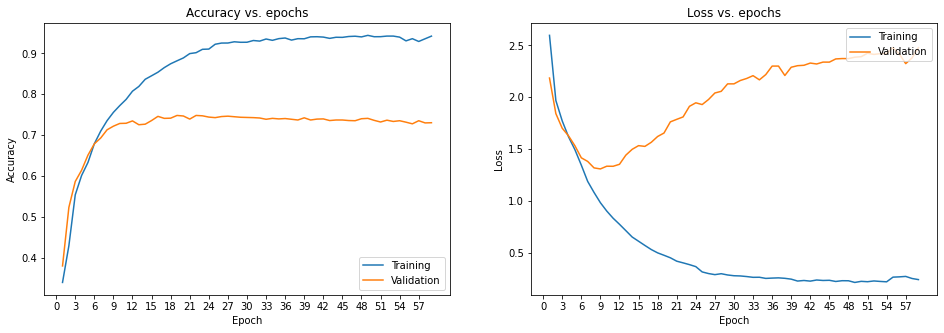

In [34]:
history = helper.train(model, batch_size=32)

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/reuters/reuters_0329_p100/sepcnn
learning_rate=0.001
checkpoint_path=./models/reuters/reuters_0329_p100/sepcnn
71/71 [==============================] - 0s 6ms/step - loss: 1.6555 - accuracy: 0.7480 - sparse_top_k_categorical_accuracy: 0.8339
loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/reuters_0329_p100/sepcnn
loading load_vectorizer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/reuters_0329_p100/SequenceTextDatasets.vectorizer
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/reuters_0329_p100/sepcnn.predictor
Test loss:1.6555, Test Accuracy:74.80%
---------------------------------------- confusion matrix ----------------------------------------
71/71 [==============================] - 0s 4ms/step


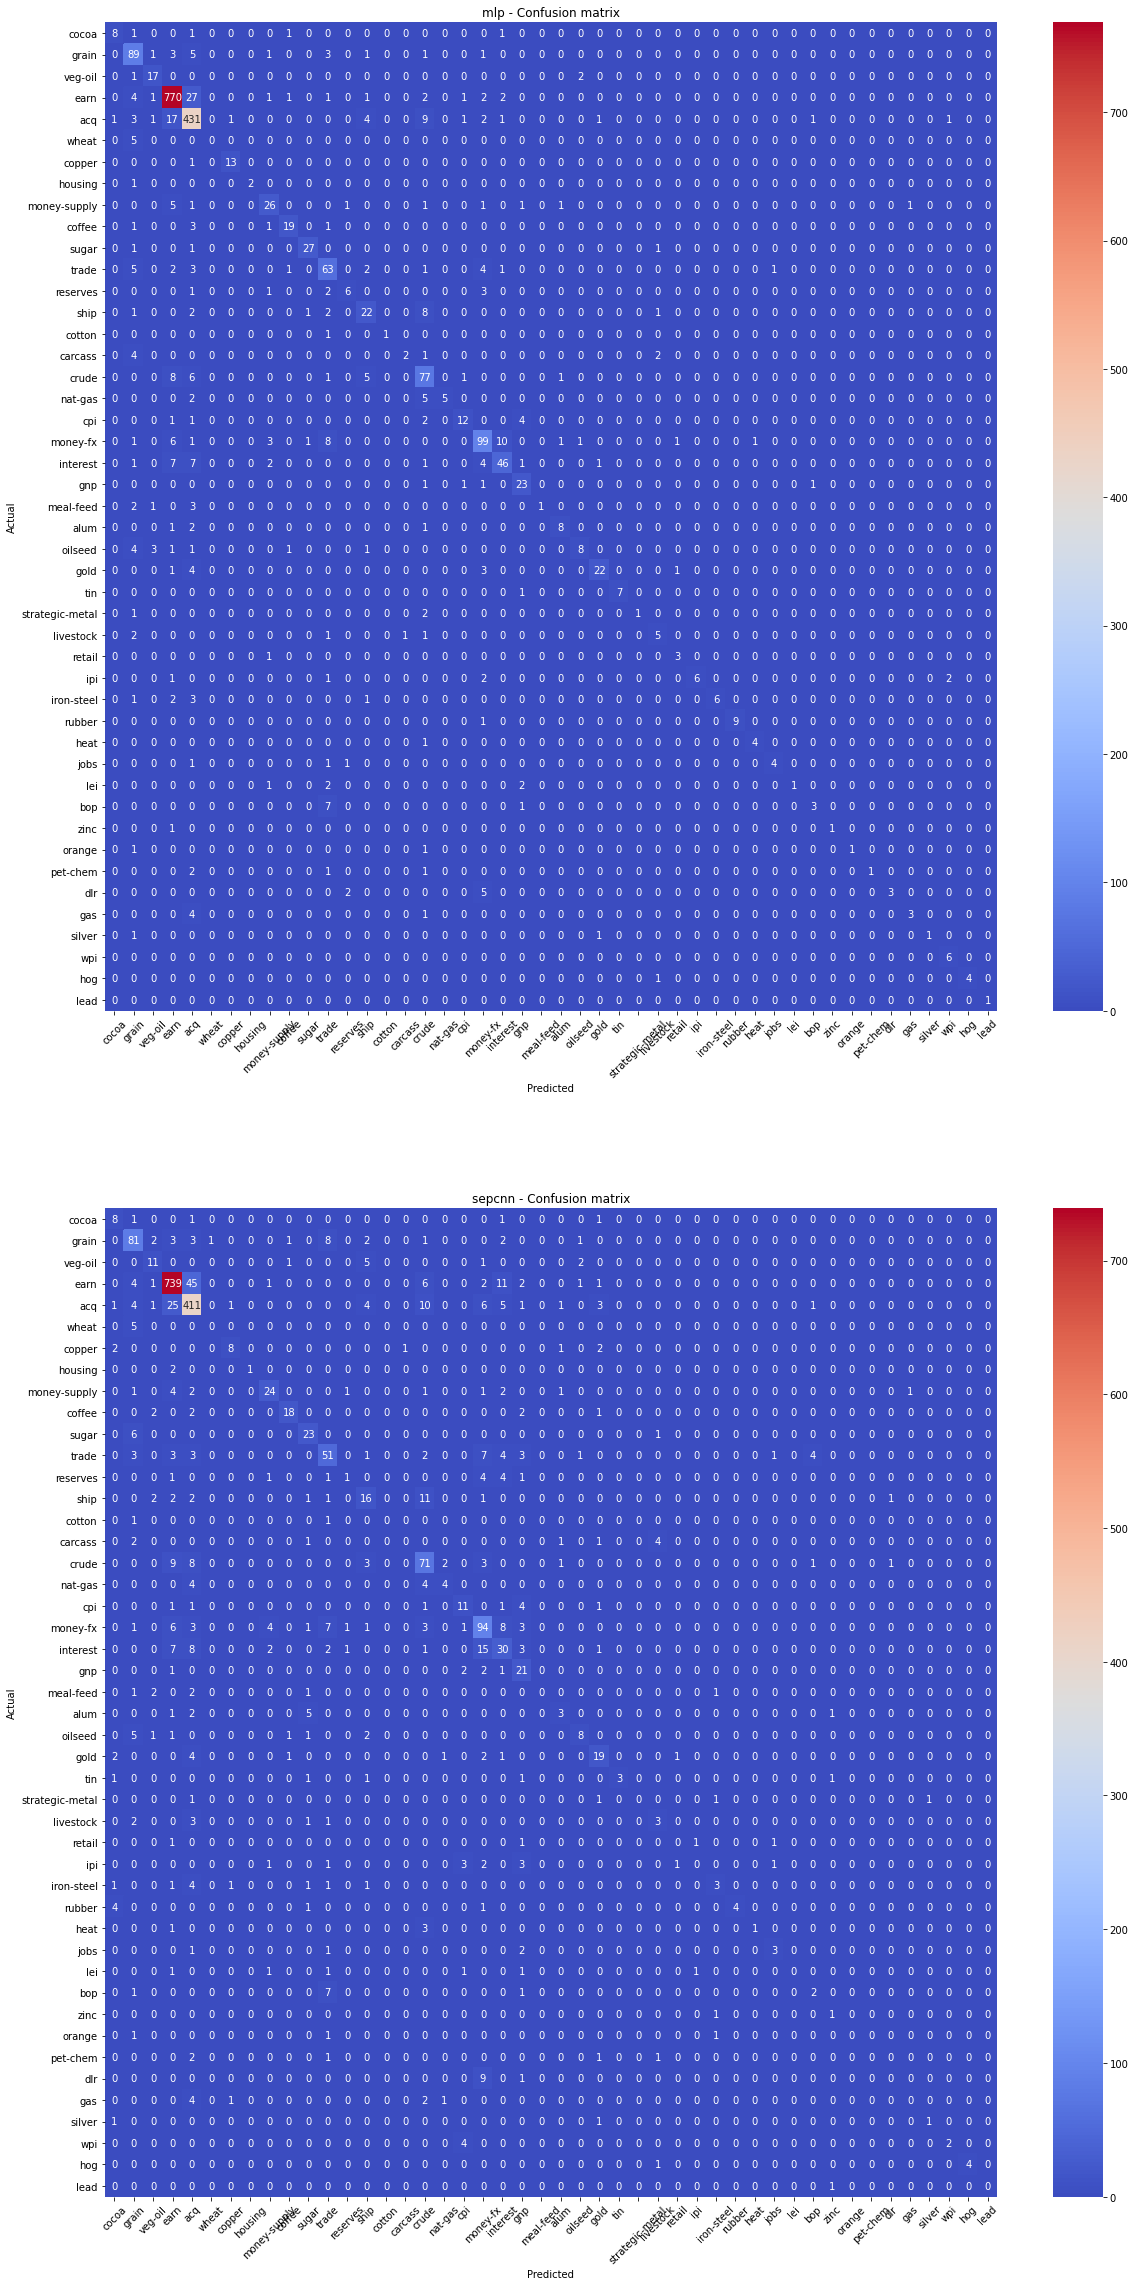

---------------------------------------- error analysis ----------------------------------------
71/71 [==============================] - 0s 4ms/step
........................................ oilseed ........................................
the commodity credit corporation ccc has reallocated 15 0 mln dlrs in credit guarantees to turkey previously earmarked for sales of u s oilseeds to provide coverage for sales of u s protein meals in fiscal year 1987 the u s agriculture department said the department said the action reduces the guarantee line authorized for sales of oilseeds to 5 0 mln dlrs from 20 0 mln dlrs and creates the new line for protein meals all sales under the credit lines must be registered and exports completed by september 30 1987 it said reuter 3


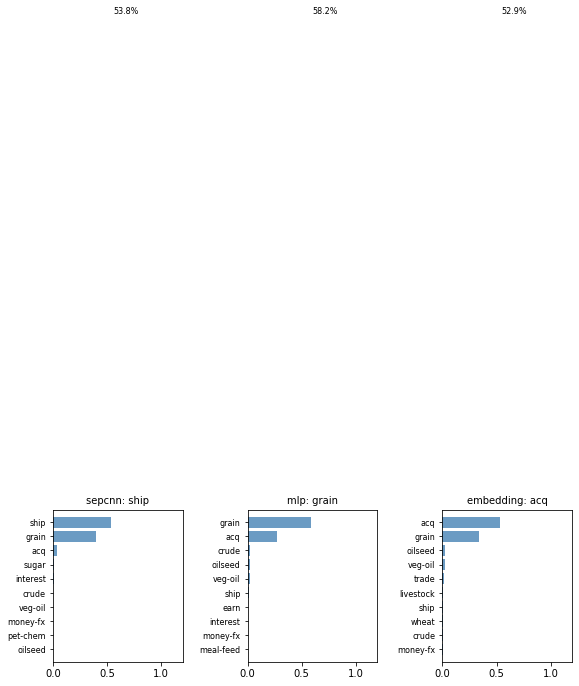

........................................ cocoa ........................................
sithe energies lp said it has signed an agreement under which it will increase its interest in energy factors inc to 70 0 pct from 53 4 pct now by investing 100 mln dlrs in energy factors stock reuter 3


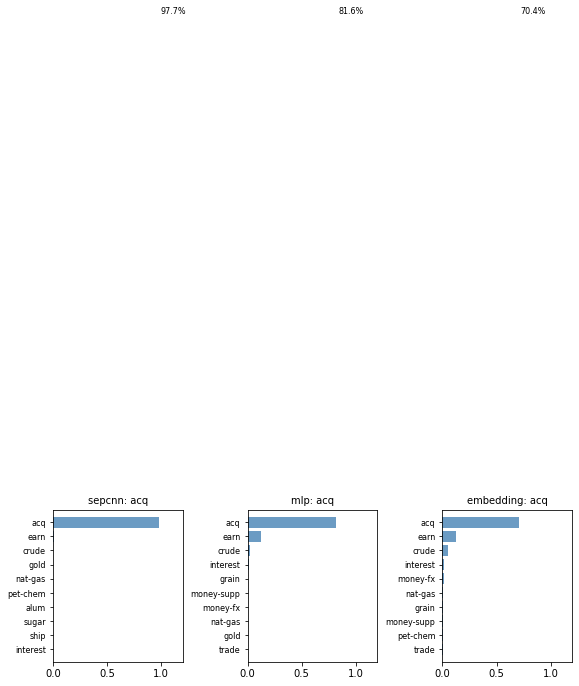

........................................ crude ........................................
shr 31 cts vs 31 cts prior payable april 24 record march 31 reuter 3


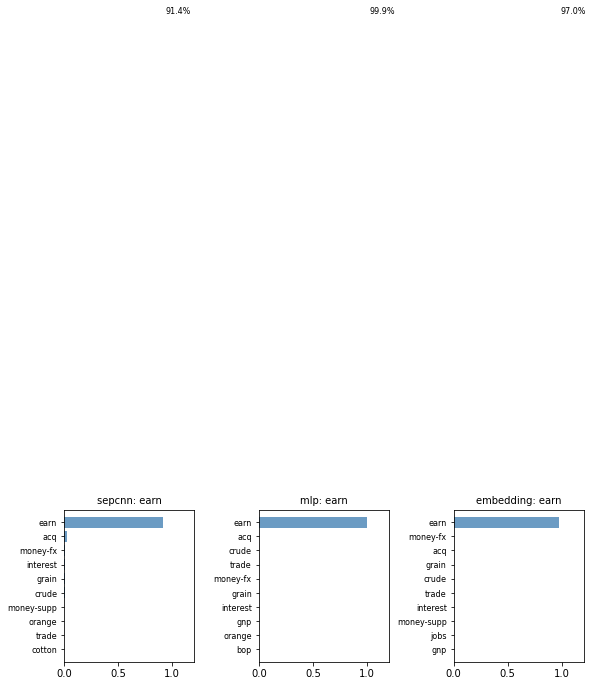

........................................ gnp ........................................
kuwait's oil reliant and debt ridden economy has started to pull out of a nosedive but oil prices will determine the pace of recovery bankers and economists say crucial will be the ability of the 13 member opec to hold oil prices around a new benchmark of 18 dlrs a barrel in the northern hemisphere summer when demand usually slackens bankers estimate the economy measured in terms of gross domestic product gdp shrank 19 pct in real terms last year after contracting 8 1 pct the year before this was after taking into account inflation in consumer prices of 1 5 pct in 1985 slowing to 1 0 pct in 1986 factors depressing economic activity include the 6 1 2 year old iran iraq war on kuwait's doorstep which threatens the emirate's vital oil export lifeline through the gulf and has sapped business confidence but sentiment received a much needed boost in september when after a series of piecemeal steps to combat

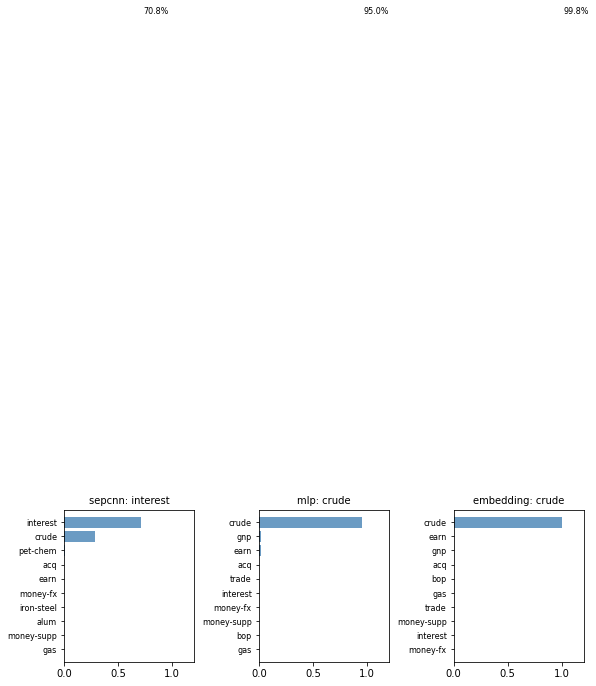

........................................ money-fx ........................................
the u s credit market ended under extreme pressure as the dollar's continued slide on the currency markets triggered an avalanche of u s securities sales pushing prices to 1987 lows dealers and analysts said this was a bloodbath said one money market economist we've been trading in a state of total panic at times today said another mirroring the dollar's fall to a 40 year low against the yen the key 7 1 2 pct 30 year treasury bond price fell nearly two points to close at 96 7 32 compared with 98 5 32 on friday the corresponding yield jumped to 7 83 pct from 7 66 reuter 3


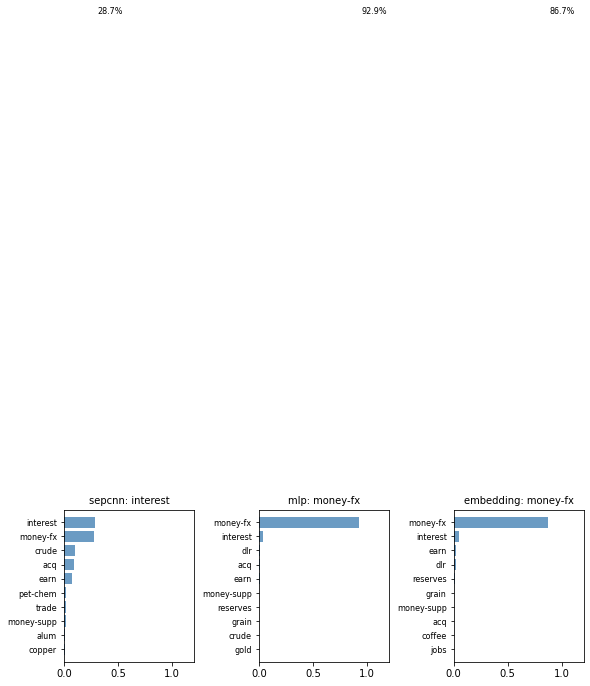

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,train_top2_accuracy,test_top2_accuracy,weight_number,train_time,predictor_path
mlp,0.190592,0.9480,0.755008,0.8313,0.9699,0.9061,5132078,90.0,/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/5...
embedding,0.210741,0.9494,0.935111,0.8130,0.9681,0.8958,4009446,598.0,/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/5...
sepcnn,0.328430,0.9234,1.655547,0.7480,0.9382,0.8339,4049358,536.0,/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/5...


save json to ./models/reuters/reuters_0329_p100/model_results.json


In [35]:
helper.model_summary(model, history=history)

### LSTM

In [ ]:
def get_lstm(helper, name='rnn_lstm', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_datasets)
model = get_lstm(helper)
model.summary()


In [ ]:
history = helper.train(model)

In [ ]:
helper.model_summary(model, history=history)

### LSTM + Bidirectional + Stacked

In [ ]:
def get_lstm_stacked(helper, name='rnn_lstm_stacked', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm_stacked(helper)
model.summary()

In [ ]:
# history = helper.train(model)

In [ ]:
# helper.model_summary(model, history=history)

## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)